# Experiments with multiple controllers

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pydove as dv

import torch
import time
import torch.nn as nn
import numpy as np

from tqdm import tqdm

from neurodmd.training import train, test
from neurodmd.bump_simulator import PlaceGridMotionSimulator
from neurodmd.multi_model import PlaceGridMultiNonBio

## Test on example with walls

In [2]:
torch.manual_seed(0)

n = 8
t0 = time.time()
simulator = PlaceGridMotionSimulator(n, sigma=0.5, fourier=False, periodic=False)

n_samples = 1_000_000
s = torch.normal(torch.zeros(n_samples), 3.0)
trajectory = simulator.batch(s)

print(f"Trajectory generation took {time.time() - t0:.2f} seconds.")

t0 = time.time()
dataset_full = [
    (trajectory[i], trajectory[i + 1], torch.relu(torch.FloatTensor([s[i], -s[i]])))
    for i in range(n_samples - 1)
]

test_size = 1000
dataset_train = dataset_full[:-test_size]
dataset_test = dataset_full[-test_size:]

batch_size = 200
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

print(f"Conversion to dataset took {time.time() - t0:.2f} seconds.")

Trajectory generation took 9.43 seconds.
Conversion to dataset took 8.75 seconds.


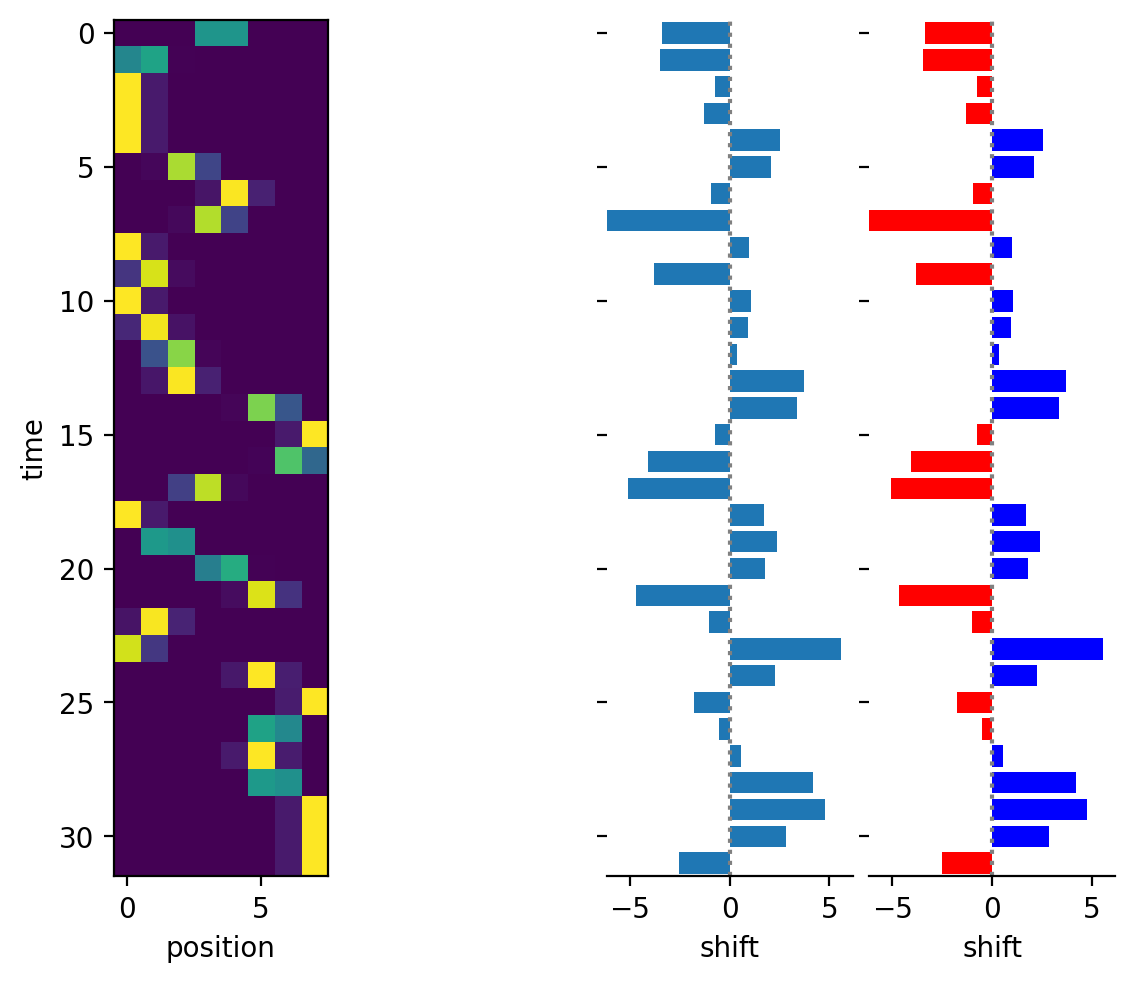

In [3]:
crt_n = 4 * n
crt_step = 1

fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, sharey=True, constrained_layout=True, gridspec_kw={"width_ratios": (3, 1, 1)}
)
ax1.imshow(trajectory[:crt_n:crt_step])
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.barh(width=s[:crt_n:crt_step], y=np.arange(0, crt_n // crt_step))
ax2.axvline(0, ls=":", c="gray")
crt_xl = max(ax2.get_xlim())
ax2.set_xlim(-crt_xl, crt_xl)
ax2.set_ylim(ax1.get_ylim())
ax2.invert_yaxis()
ax2.set_xlabel("shift")
sns.despine(ax=ax2, left=True)

crt_s2 = torch.vstack([_[-1] for _ in dataset_full[:crt_n:crt_step]])

ax3.barh(width=crt_s2[:, 0], y=np.arange(0, crt_n // crt_step), color="blue")
ax3.barh(width=-crt_s2[:, 1], y=np.arange(0, crt_n // crt_step), color="red")
ax3.axvline(0, ls=":", c="gray")
crt_xl = max(ax3.get_xlim())
ax3.set_xlim(-crt_xl, crt_xl)
ax3.set_ylim(ax1.get_ylim())
ax3.invert_yaxis()
ax3.set_xlabel("shift")
sns.despine(ax=ax3, left=True)

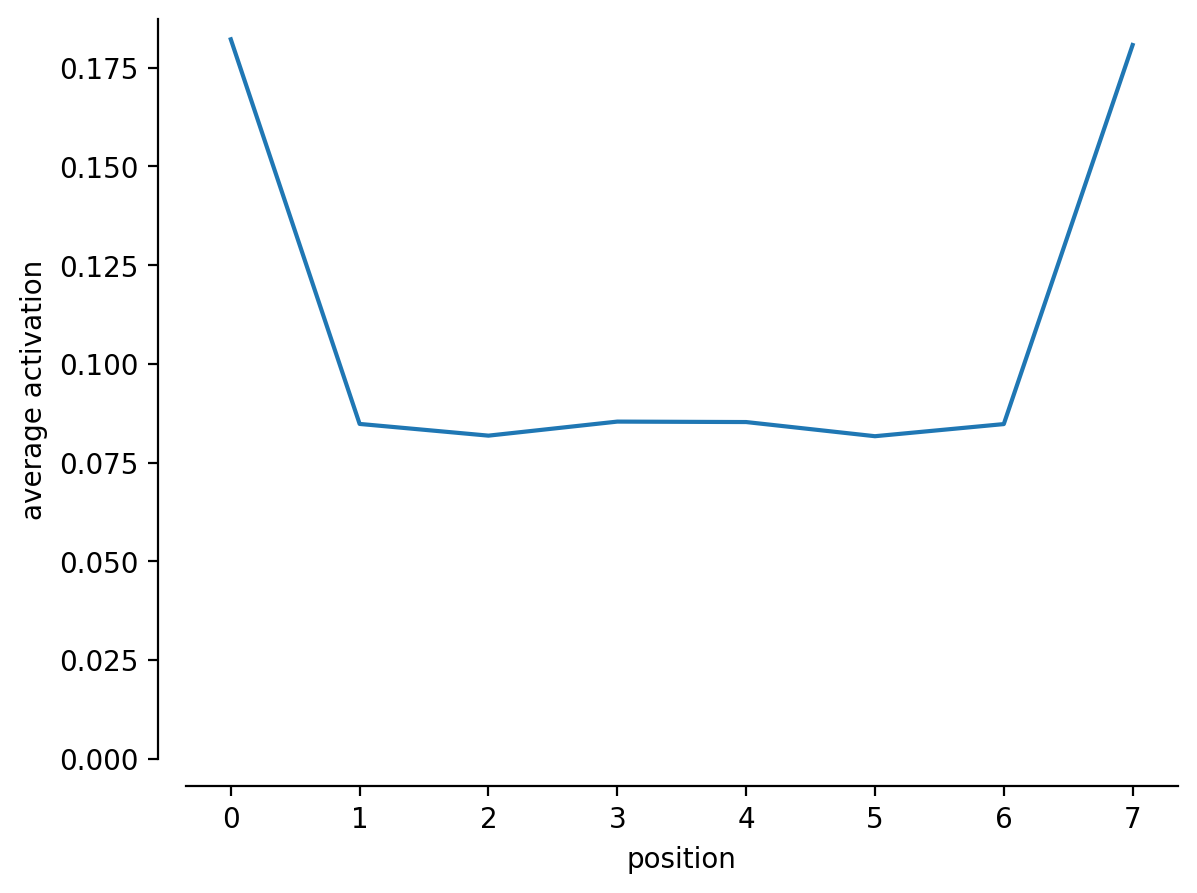

In [4]:
fig, ax = plt.subplots()
ax.plot(torch.mean(trajectory, dim=0))
ax.set_ylim(0, None)

ax.set_xlabel("position")
ax.set_ylabel("average activation")
sns.despine(ax=ax, offset=10)

In [5]:
torch.manual_seed(0)

t0 = time.time()
m = n - 1

system = PlaceGridMultiNonBio(2, n, m)

original_U = torch.clone(system.U).detach()
original_V = torch.clone(system.V).detach()
original_xi = torch.clone(system.xi).detach()
original_theta = torch.clone(system.theta).detach()

optimizer = torch.optim.AdamW(system.parameters(), lr=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.999)
# scheduler = StepwiseScheduler(
#     optimizer,
#     [(100, 0.01), (100, 0.05), (100, 0.03), (300, 0.02), (1600, 0.01), (100, 0.005)]
# )
# scheduler = None
train_results = train(
    system,
    "cpu",
    dataloader_train,
    optimizer,
    test_set=dataloader_test,
    test_every=50,
    scheduler=scheduler,
)
dt = time.time() - t0
print(f"Training took {dt:.2f} seconds, {n_samples / dt:.2f} steps / second.")

100%|██████████| 998999/998999 [00:18<00:00, 55366.67it/s, train batch loss: 0.001771]

Training took 18.06 seconds, 55375.89 steps / second.


In [6]:
scheduler.get_last_lr()

[0.0033774092860272887]

In [7]:
(
    torch.median(torch.abs(system.U - original_U)),
    torch.median(torch.abs(system.V - original_V)),
    torch.median(torch.abs(system.xi - original_xi)),
    torch.median(torch.abs(system.theta - original_theta)),
)

(tensor(0.3334, grad_fn=<MedianBackward0>),
 tensor(0.3911, grad_fn=<MedianBackward0>),
 tensor(0.6786, grad_fn=<MedianBackward0>),
 tensor(1.3599, grad_fn=<MedianBackward0>))

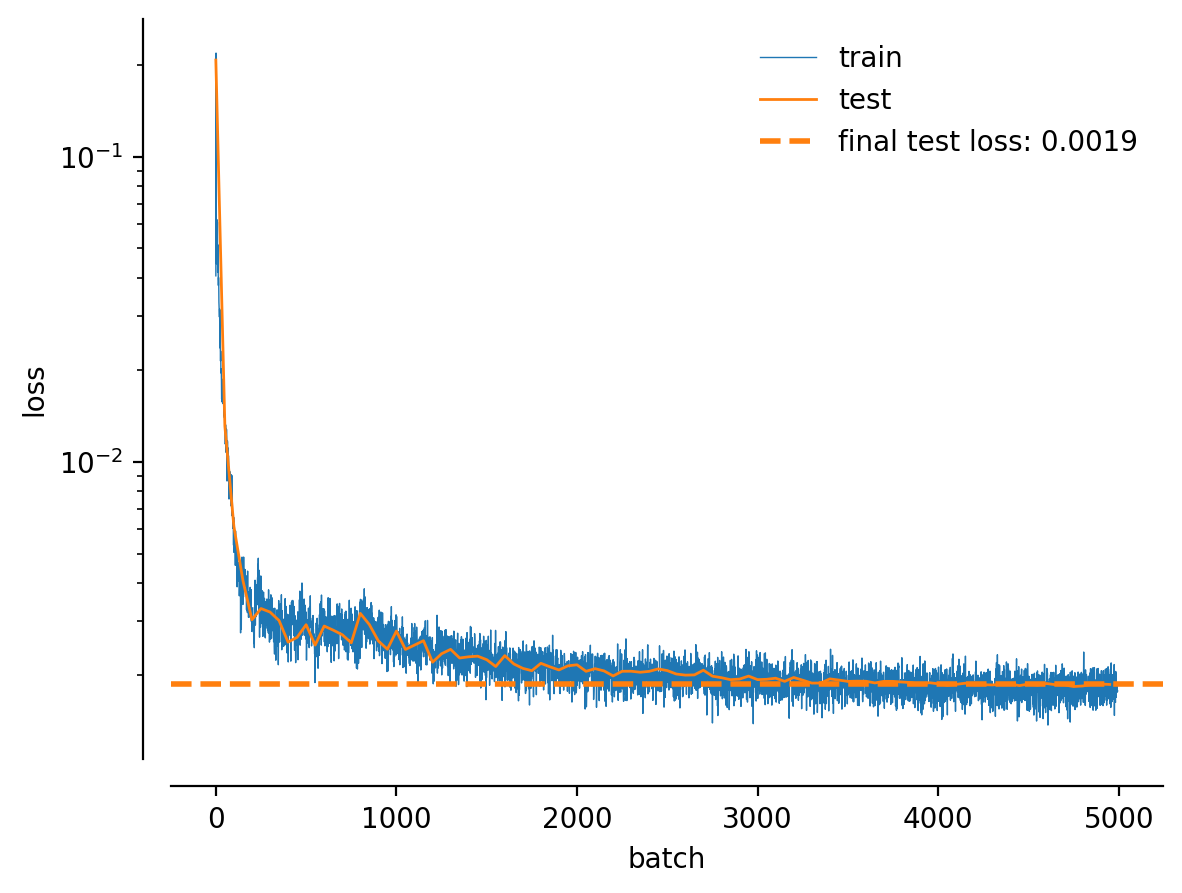

In [8]:
fig, ax = plt.subplots()
ax.semilogy(train_results.train_loss, lw=0.5, label="train")
ax.semilogy(train_results.test_idxs, train_results.test_loss, lw=1.0, label="test")
ax.set_xlabel("batch")
ax.set_ylabel("loss")

ax.axhline(
    train_results.test_loss[-1],
    lw=2.0,
    ls="--",
    c="C1",
    label=f"final test loss: {train_results.test_loss[-1]:.2g}"
)

ax.legend(frameon=False)

sns.despine(ax=ax, offset=10)

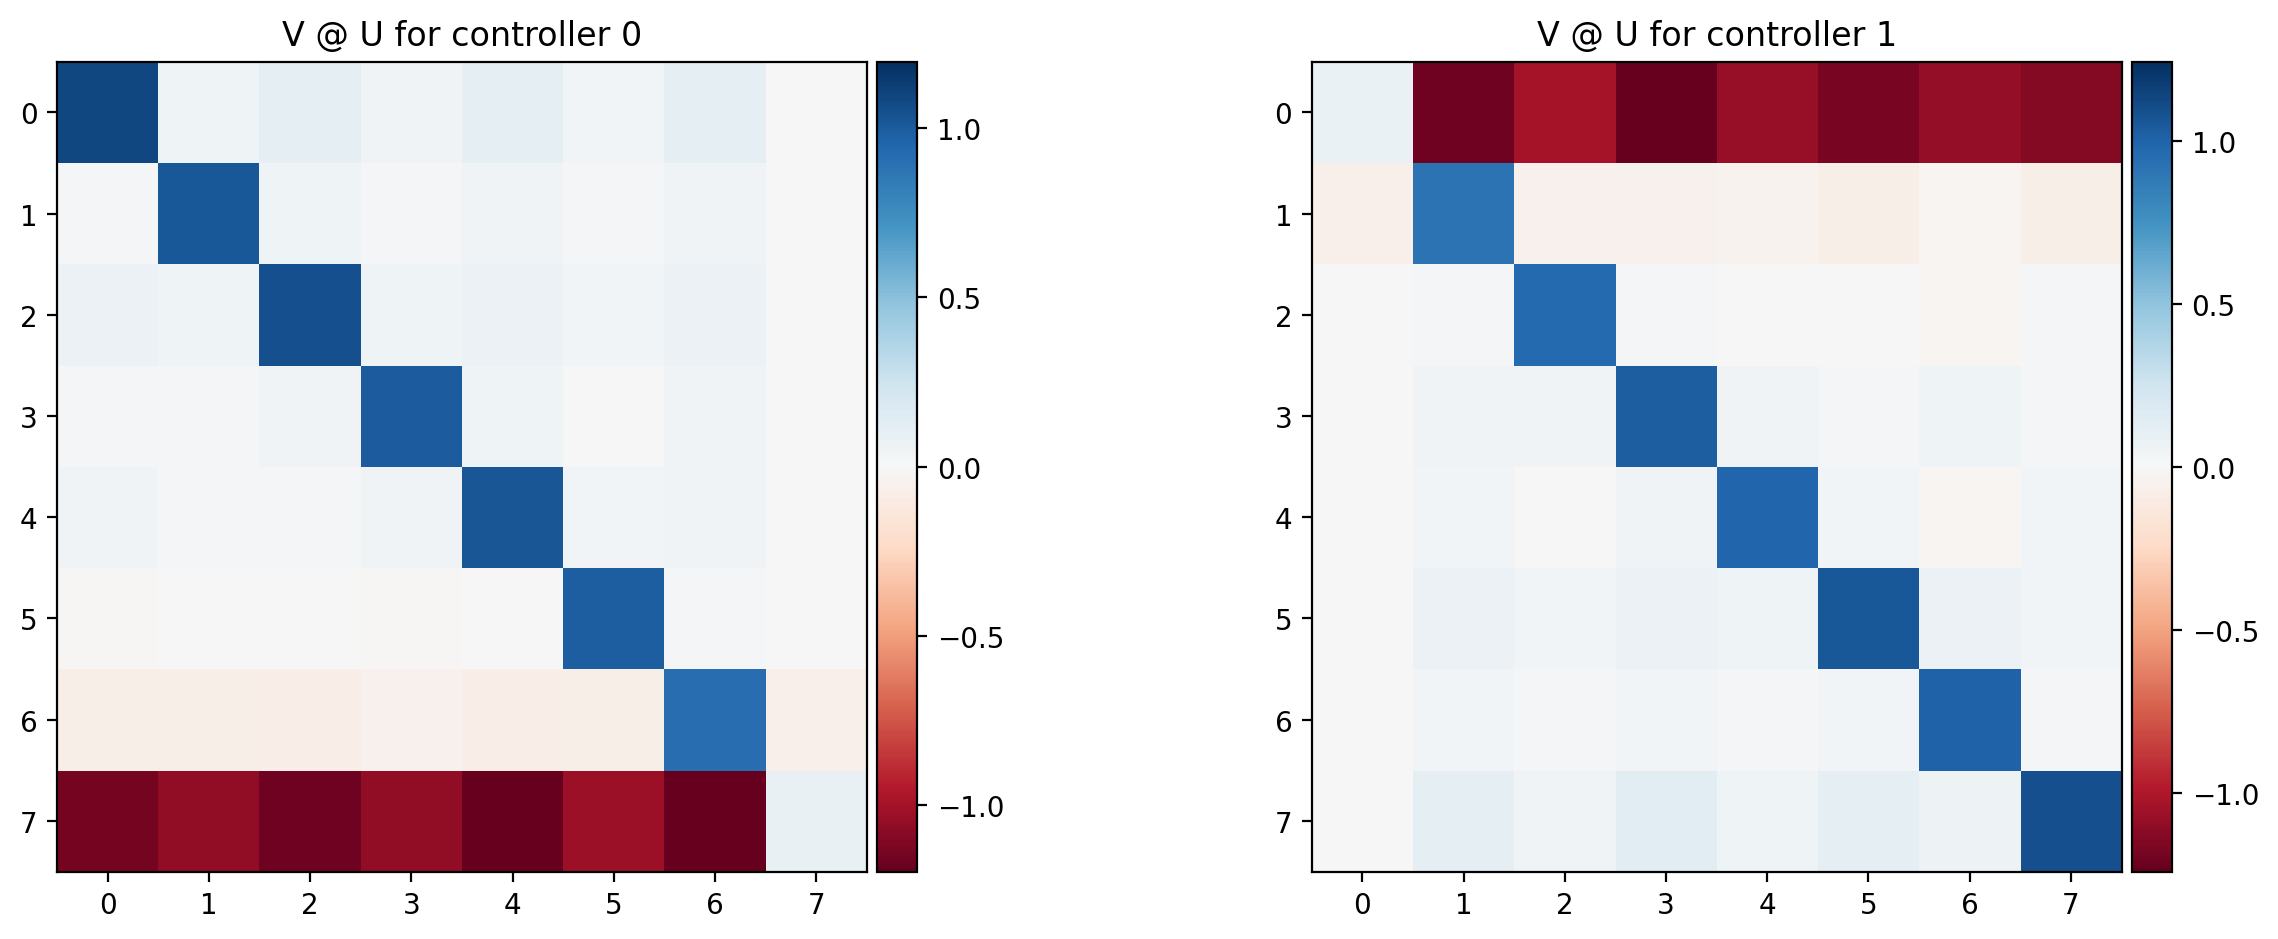

In [9]:
with dv.FigureManager(1, 2, do_despine=False) as (_, axs):
    for k, ax in enumerate(axs):
        crt_tensor = (system.V[k] @ system.U[k]).detach().numpy()
        crt_lim = np.max(np.abs(crt_tensor))
        h = ax.imshow(crt_tensor, cmap="RdBu", vmin=-crt_lim, vmax=crt_lim)
        dv.colorbar(h)
        
        ax.set_title(f"V @ U for controller {k}")

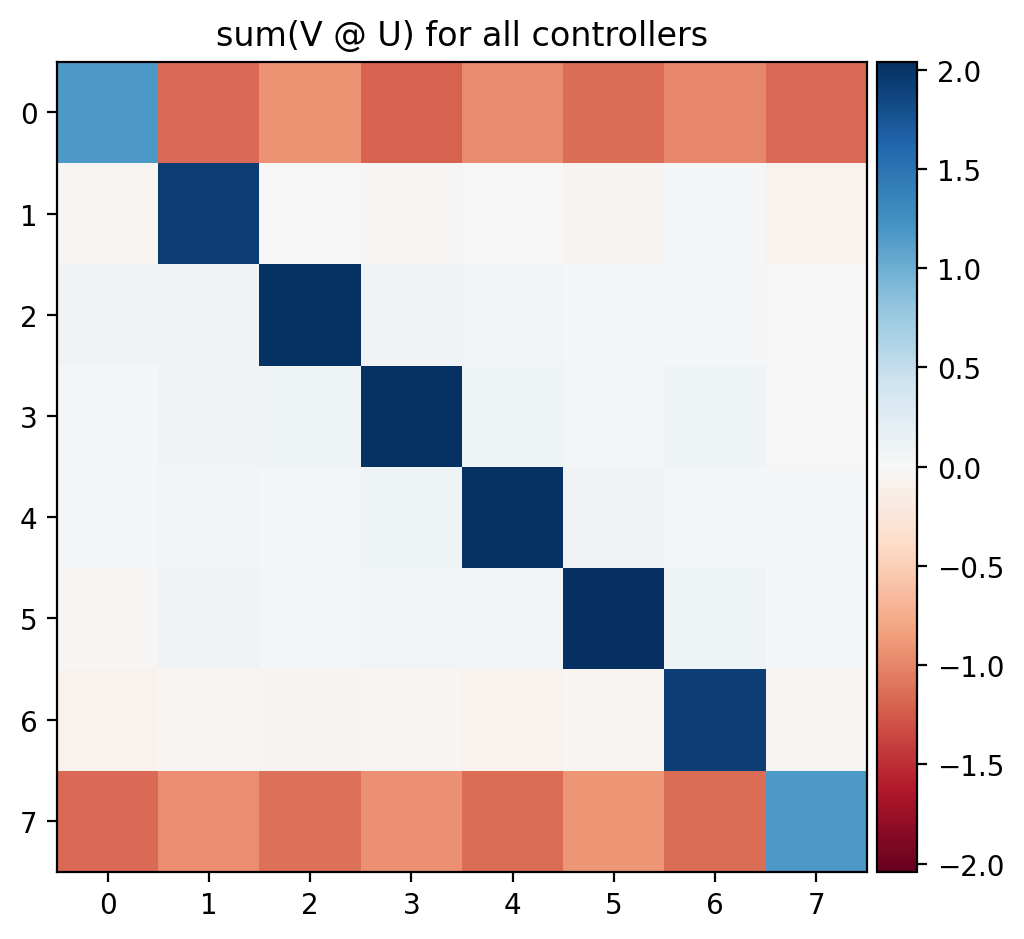

In [10]:
with dv.FigureManager(do_despine=False) as (_, ax):
    crt_tensor = sum((system.V[k] @ system.U[k]).detach().numpy() for k in range(2))
    crt_lim = np.max(np.abs(crt_tensor))
    h = ax.imshow(crt_tensor, cmap="RdBu", vmin=-crt_lim, vmax=crt_lim)
    dv.colorbar(h)
        
    ax.set_title("sum(V @ U) for all controllers")

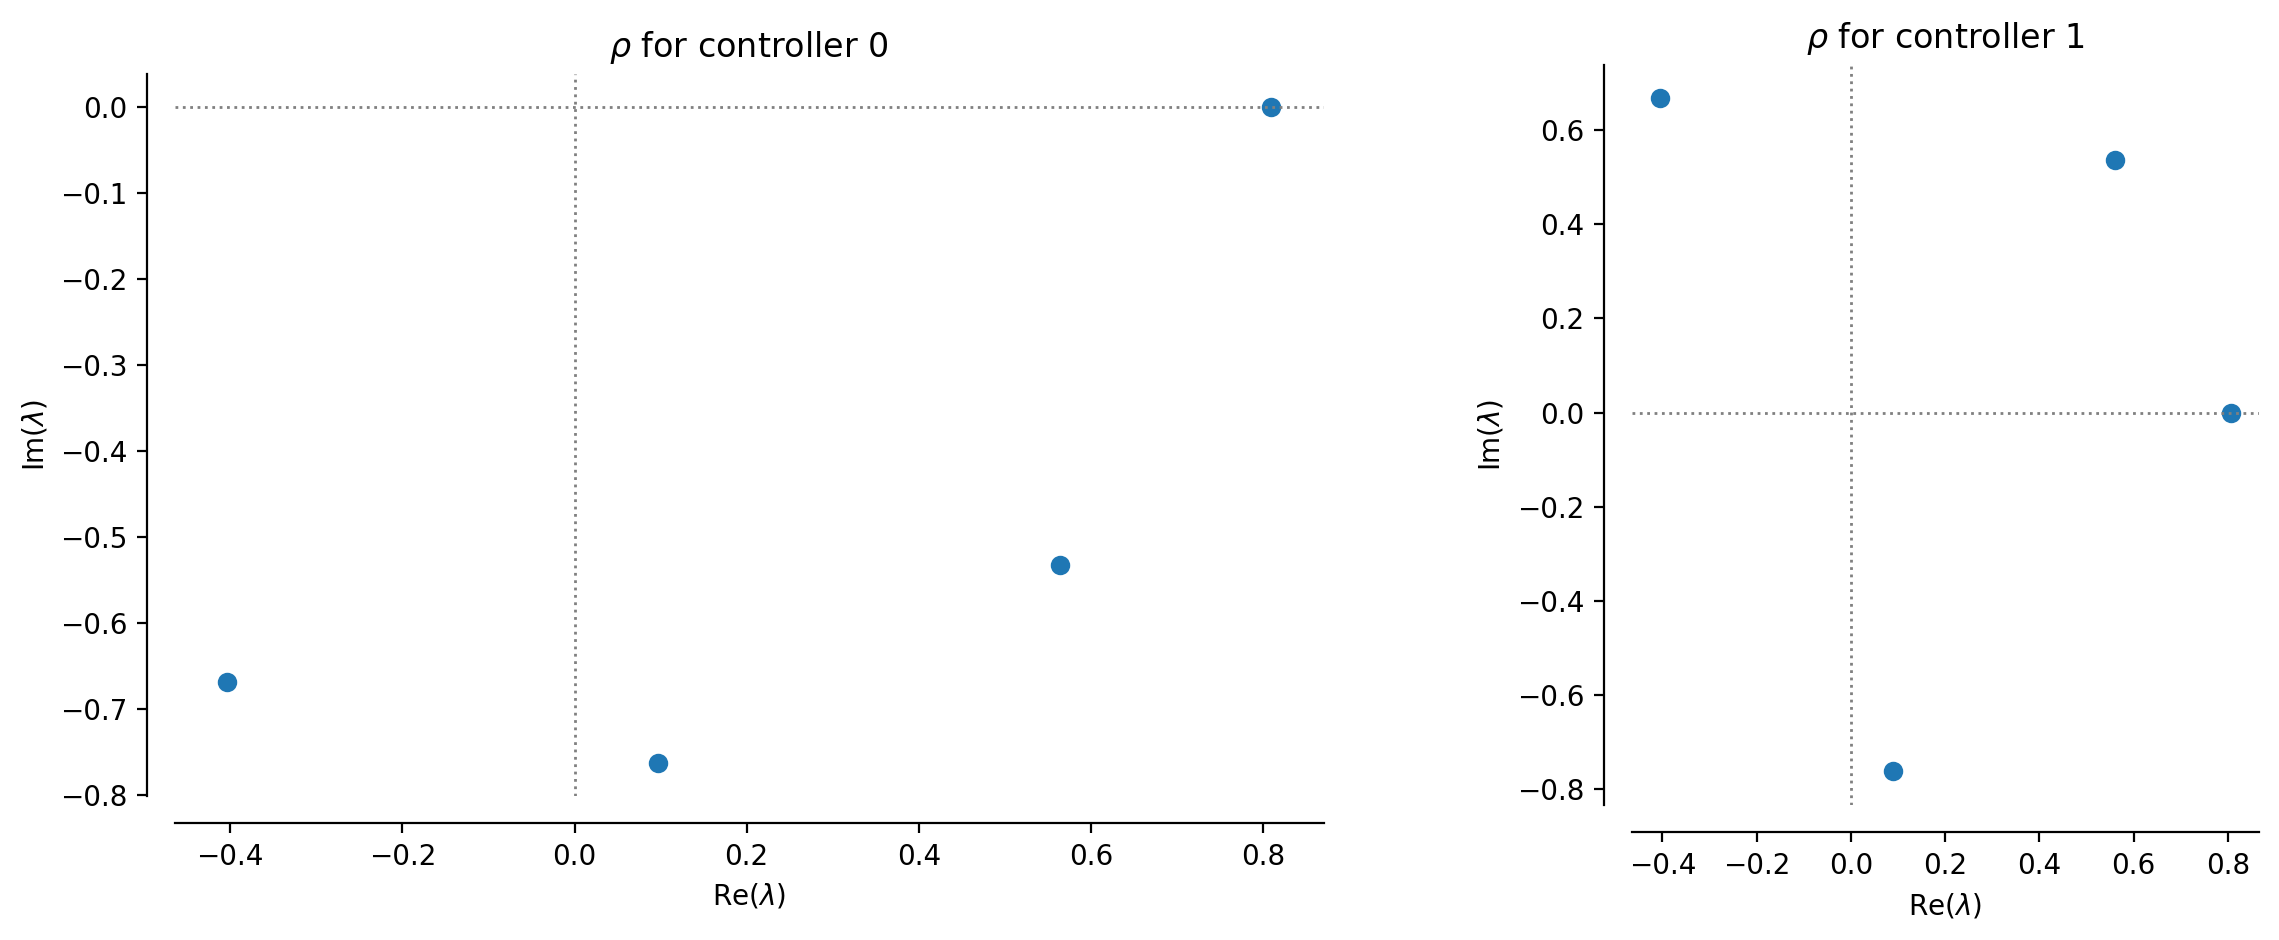

In [11]:
with dv.FigureManager(1, 2) as (_, axs):
    for k, ax in enumerate(axs):
        crt_rho = (1 / torch.cosh(system.xi[k])).detach().numpy()
        crt_theta = system.theta[k].detach().numpy()
        crt_v = crt_rho[:len(crt_theta)] * np.exp(1j * crt_theta)
        if len(crt_rho) > len(crt_theta):
            crt_v = np.hstack((crt_v, [crt_rho[-1]]))

        ax.axhline(0, ls=":", lw=1, c="gray")
        ax.axvline(0, ls=":", lw=1, c="gray")

        ax.scatter(crt_v.real, crt_v.imag)
        ax.set_aspect(1)
        ax.set_xlabel("Re($\\lambda$)")
        ax.set_ylabel("Im($\\lambda$)")
        
        ax.set_title(f"$\\rho$ for controller {k}")

In [12]:
(
    torch.max(torch.abs(system.U)),
    torch.max(torch.abs(system.V)),
)

(tensor(1.2552, grad_fn=<MaxBackward1>),
 tensor(2.1931, grad_fn=<MaxBackward1>))

### Try learned system on examples

In [13]:
torch.manual_seed(1)

test_simulator = PlaceGridMotionSimulator(n, sigma=1.0, fourier=False, periodic=False)

test_n_samples = 20
test_x = n * torch.rand(test_n_samples)
test_trajectory = []
for i in range(test_n_samples):
    test_simulator.x = test_x[i].item()
    test_trajectory.append(test_simulator().type(torch.float32))

test_trajectory = torch.stack(test_trajectory)

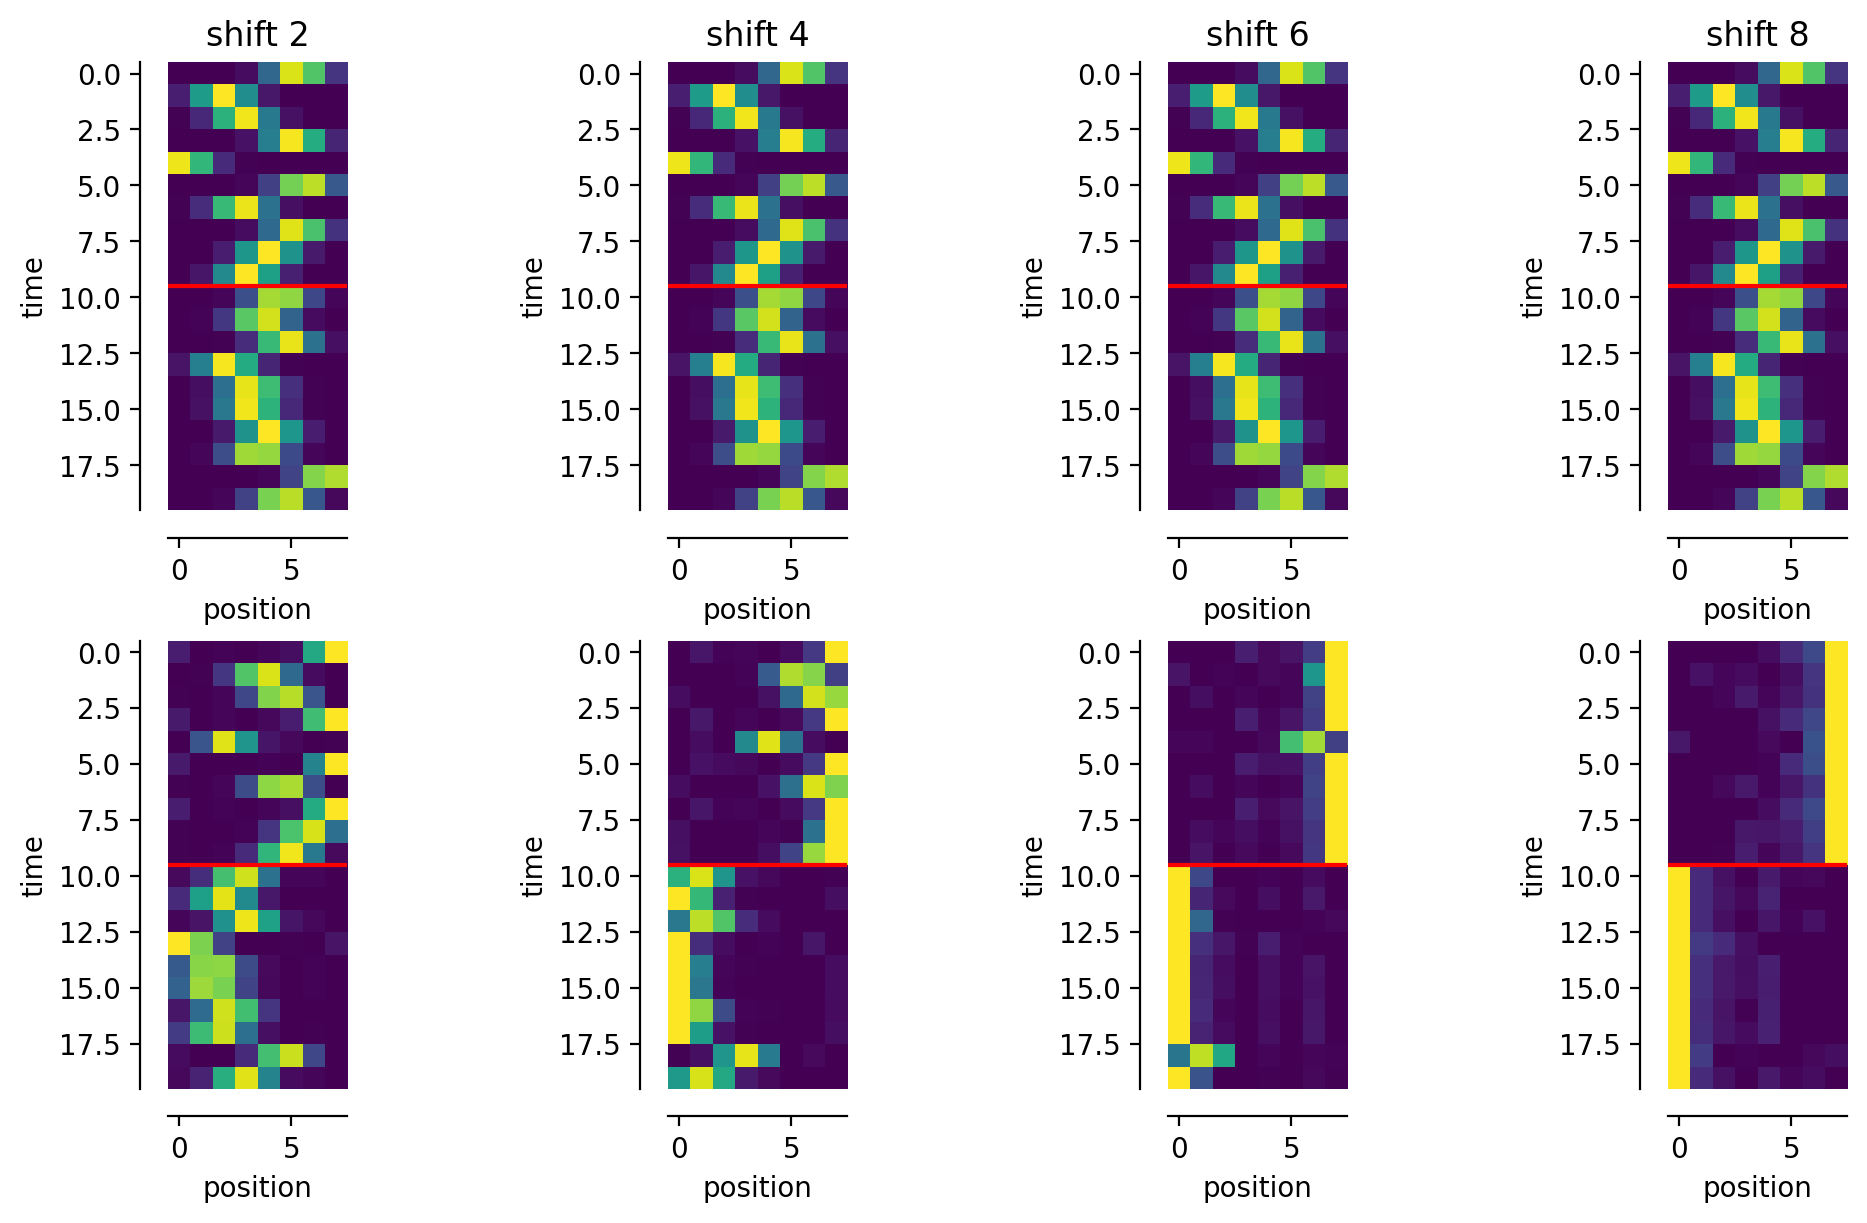

In [14]:
shifts = 2 * np.arange(1, 5)
with dv.FigureManager(2, len(shifts), constrained_layout=True, figsize=(2.5 * len(shifts), 6)) as (_, axs):
    crt_max = torch.max(test_trajectory)
    for i in range(len(shifts)):
        left_motion = torch.tensor([1.0, 0.0]).tile(test_n_samples // 2, 1)
        right_motion = torch.tensor([0.0, 1.0]).tile(test_n_samples // 2, 1)
        all_s = torch.vstack((left_motion, right_motion))
        test_moved = system.propagate_place(test_trajectory, shifts[i] * all_s)
        
        ax1, ax2 = axs[:, i]

        ax1.imshow(test_trajectory, vmin=0, vmax=crt_max)
        ax1.set_ylabel("time")
        ax1.set_xlabel("position")

        ax1.axhline(test_n_samples // 2 - 0.5, color="red")
        
        ax1.set_title(f"shift {shifts[i]}")

        ax2.imshow(test_moved.detach().numpy(), vmin=0, vmax=crt_max)
        ax2.set_ylabel("time")
        ax2.set_xlabel("position")

        ax2.axhline(test_n_samples // 2 - 0.5, color="red")

In [15]:
[
    [torch.min(torch.abs(system.xi[_])), torch.max(torch.abs(system.xi[_]))]
    for _ in range(system.n_ctrl)
]

[[tensor(0.6729, grad_fn=<MinBackward1>),
  tensor(0.7580, grad_fn=<MaxBackward1>)],
 [tensor(0.6796, grad_fn=<MinBackward1>),
  tensor(0.7622, grad_fn=<MaxBackward1>)]]

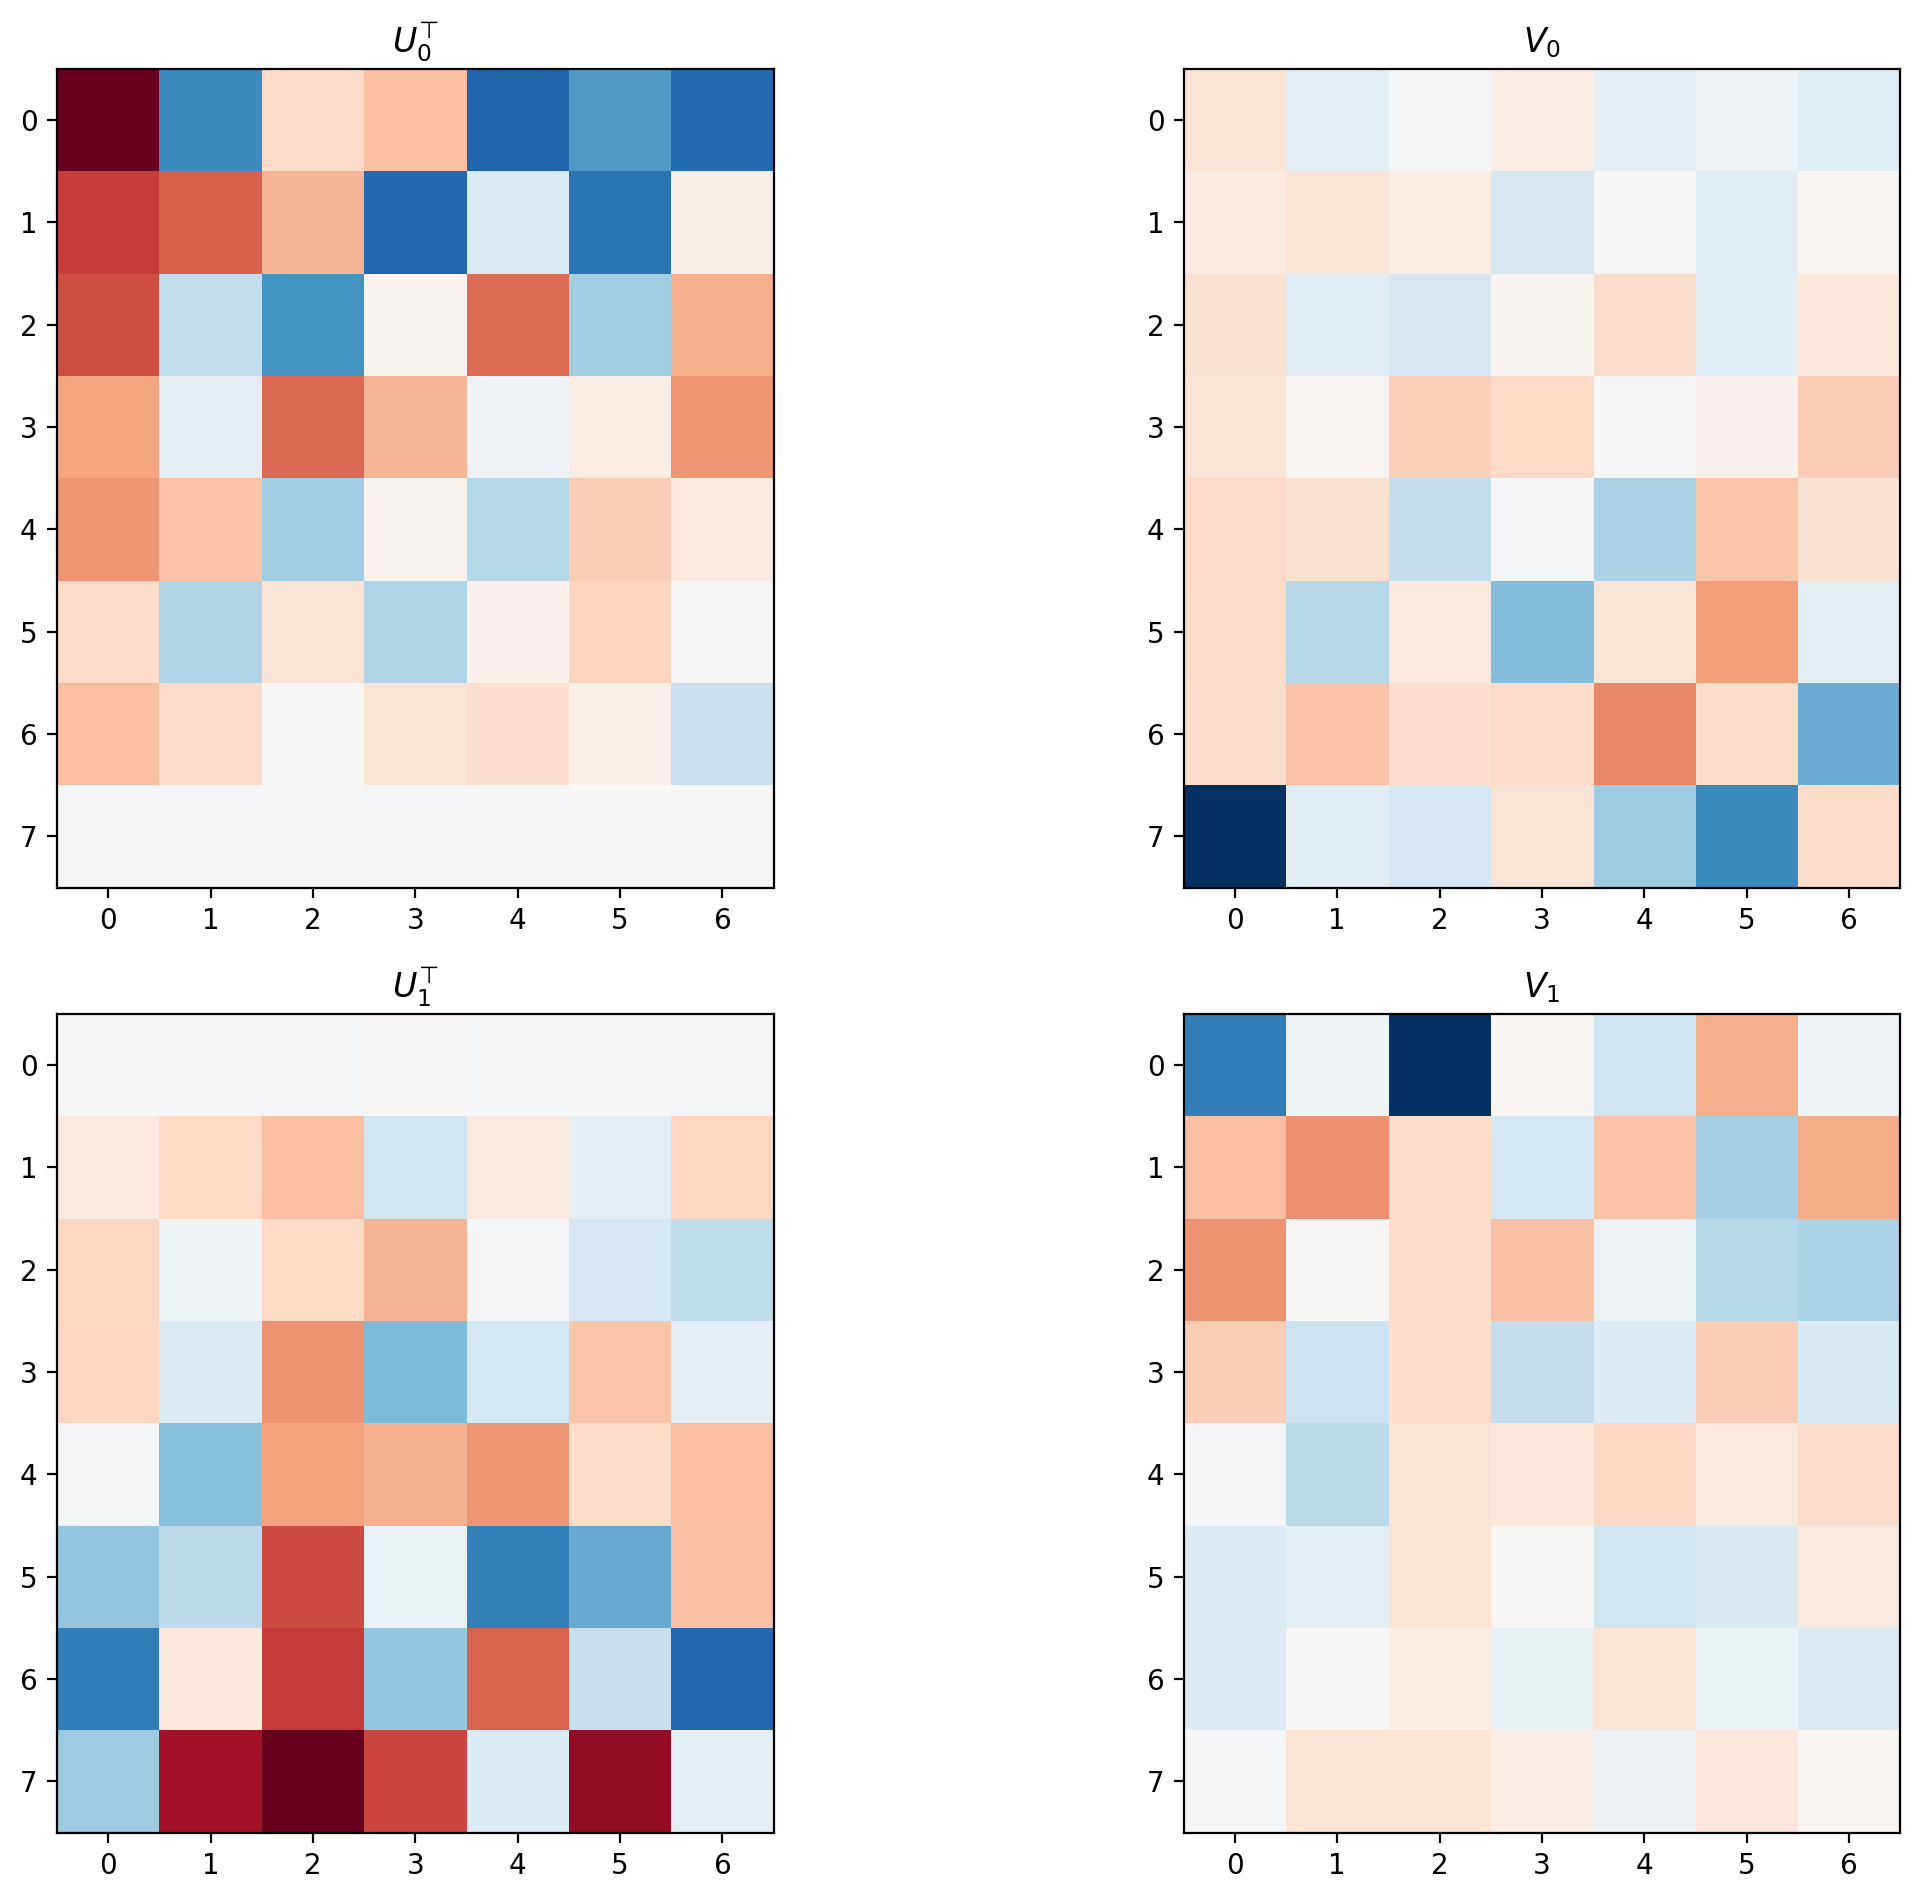

In [16]:
with dv.FigureManager(system.n_ctrl, 2, do_despine=False) as (_, axs):
    for k in range(system.n_ctrl):
        crt_d = {f"$U_{k}^\\top$": system.U[k].T, f"$V_{k}$": system.V[k]}
        
        crt_theta = system.theta[k].detach().numpy()
        crt_full_theta = np.repeat(crt_theta, 2)
        
        crt_rho = (1 / torch.cosh(system.xi[k])).detach().numpy()
        if len(crt_theta) % 2 == 0:
            crt_full_rho = np.repeat(crt_rho, 2)
        else:
            crt_full_rho = np.hstack((np.repeat(crt_rho[:-1], 2), crt_rho[[-1]]))
            crt_full_theta = np.hstack((crt_full_theta, [0]))
        
        crt_value = crt_full_rho + 0.02 * (crt_full_theta % (2 * np.pi))
        crt_ordering = np.argsort(crt_value)
        ax_row = axs[k]
        for i, crt_name in enumerate(crt_d):
            ax = ax_row[i]
            crt_mat = crt_d[crt_name].detach().numpy()

            crt_mat = crt_mat[:, crt_ordering]

            crt_lim = np.max(np.abs(crt_mat))

            ax.imshow(crt_mat, vmin=-crt_lim, vmax=crt_lim, cmap="RdBu")

            ax.set_title(crt_name)

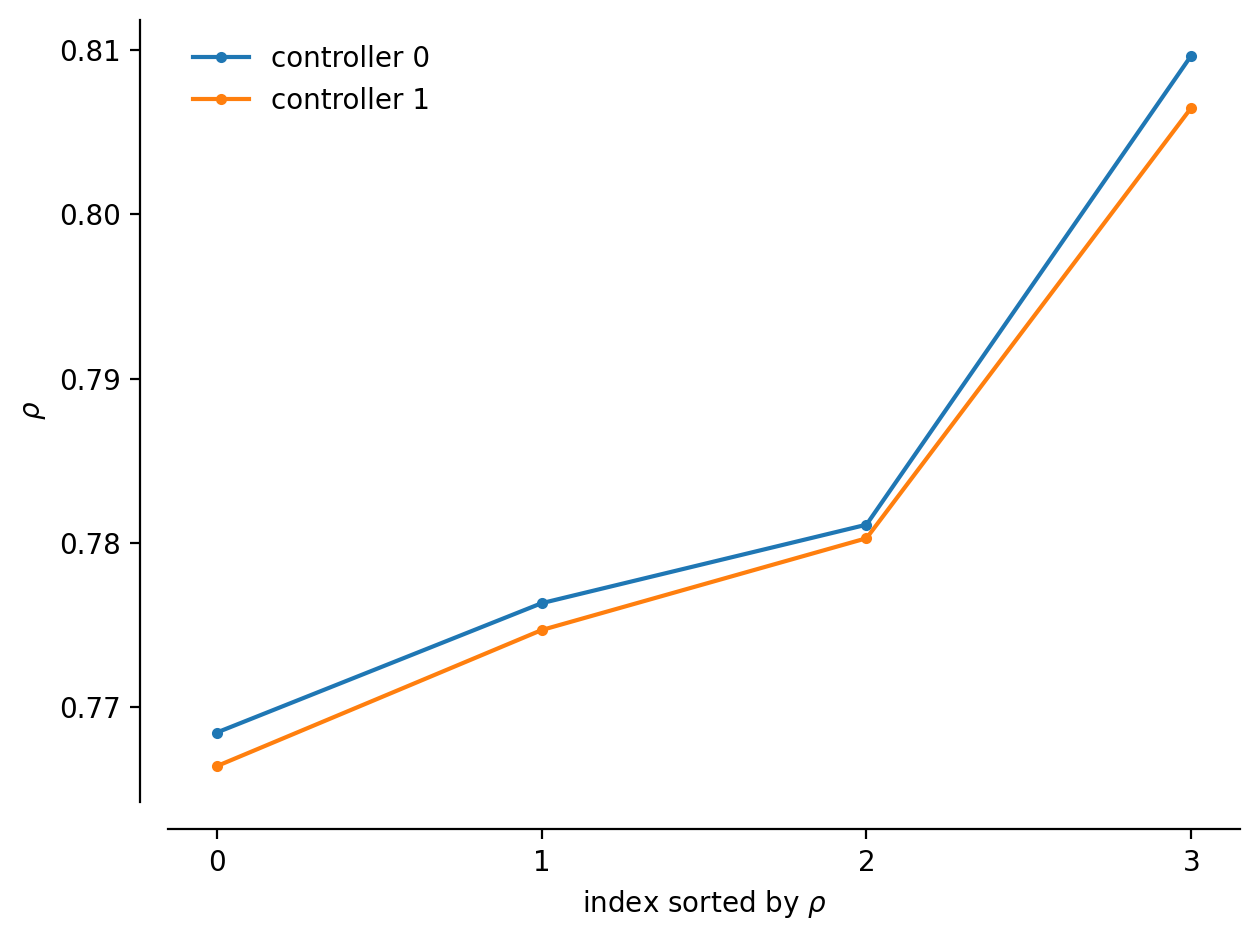

In [17]:
with dv.FigureManager() as (_, ax):
    for k in range(system.n_ctrl):
        crt_rho = (1 / torch.cosh(system.xi[k])).detach().numpy()
        ax.plot(sorted(crt_rho), ".-", label=f"controller {k}")
        # ax.plot(crt_rho, ".-", label=f"controller {k}")
        
    ax.set_xlabel("index sorted by $\\rho$")
    ax.set_ylabel("$\\rho$")
    ax.legend(frameon=False)
    
    ax.set_xticks(np.arange(len(crt_rho)))

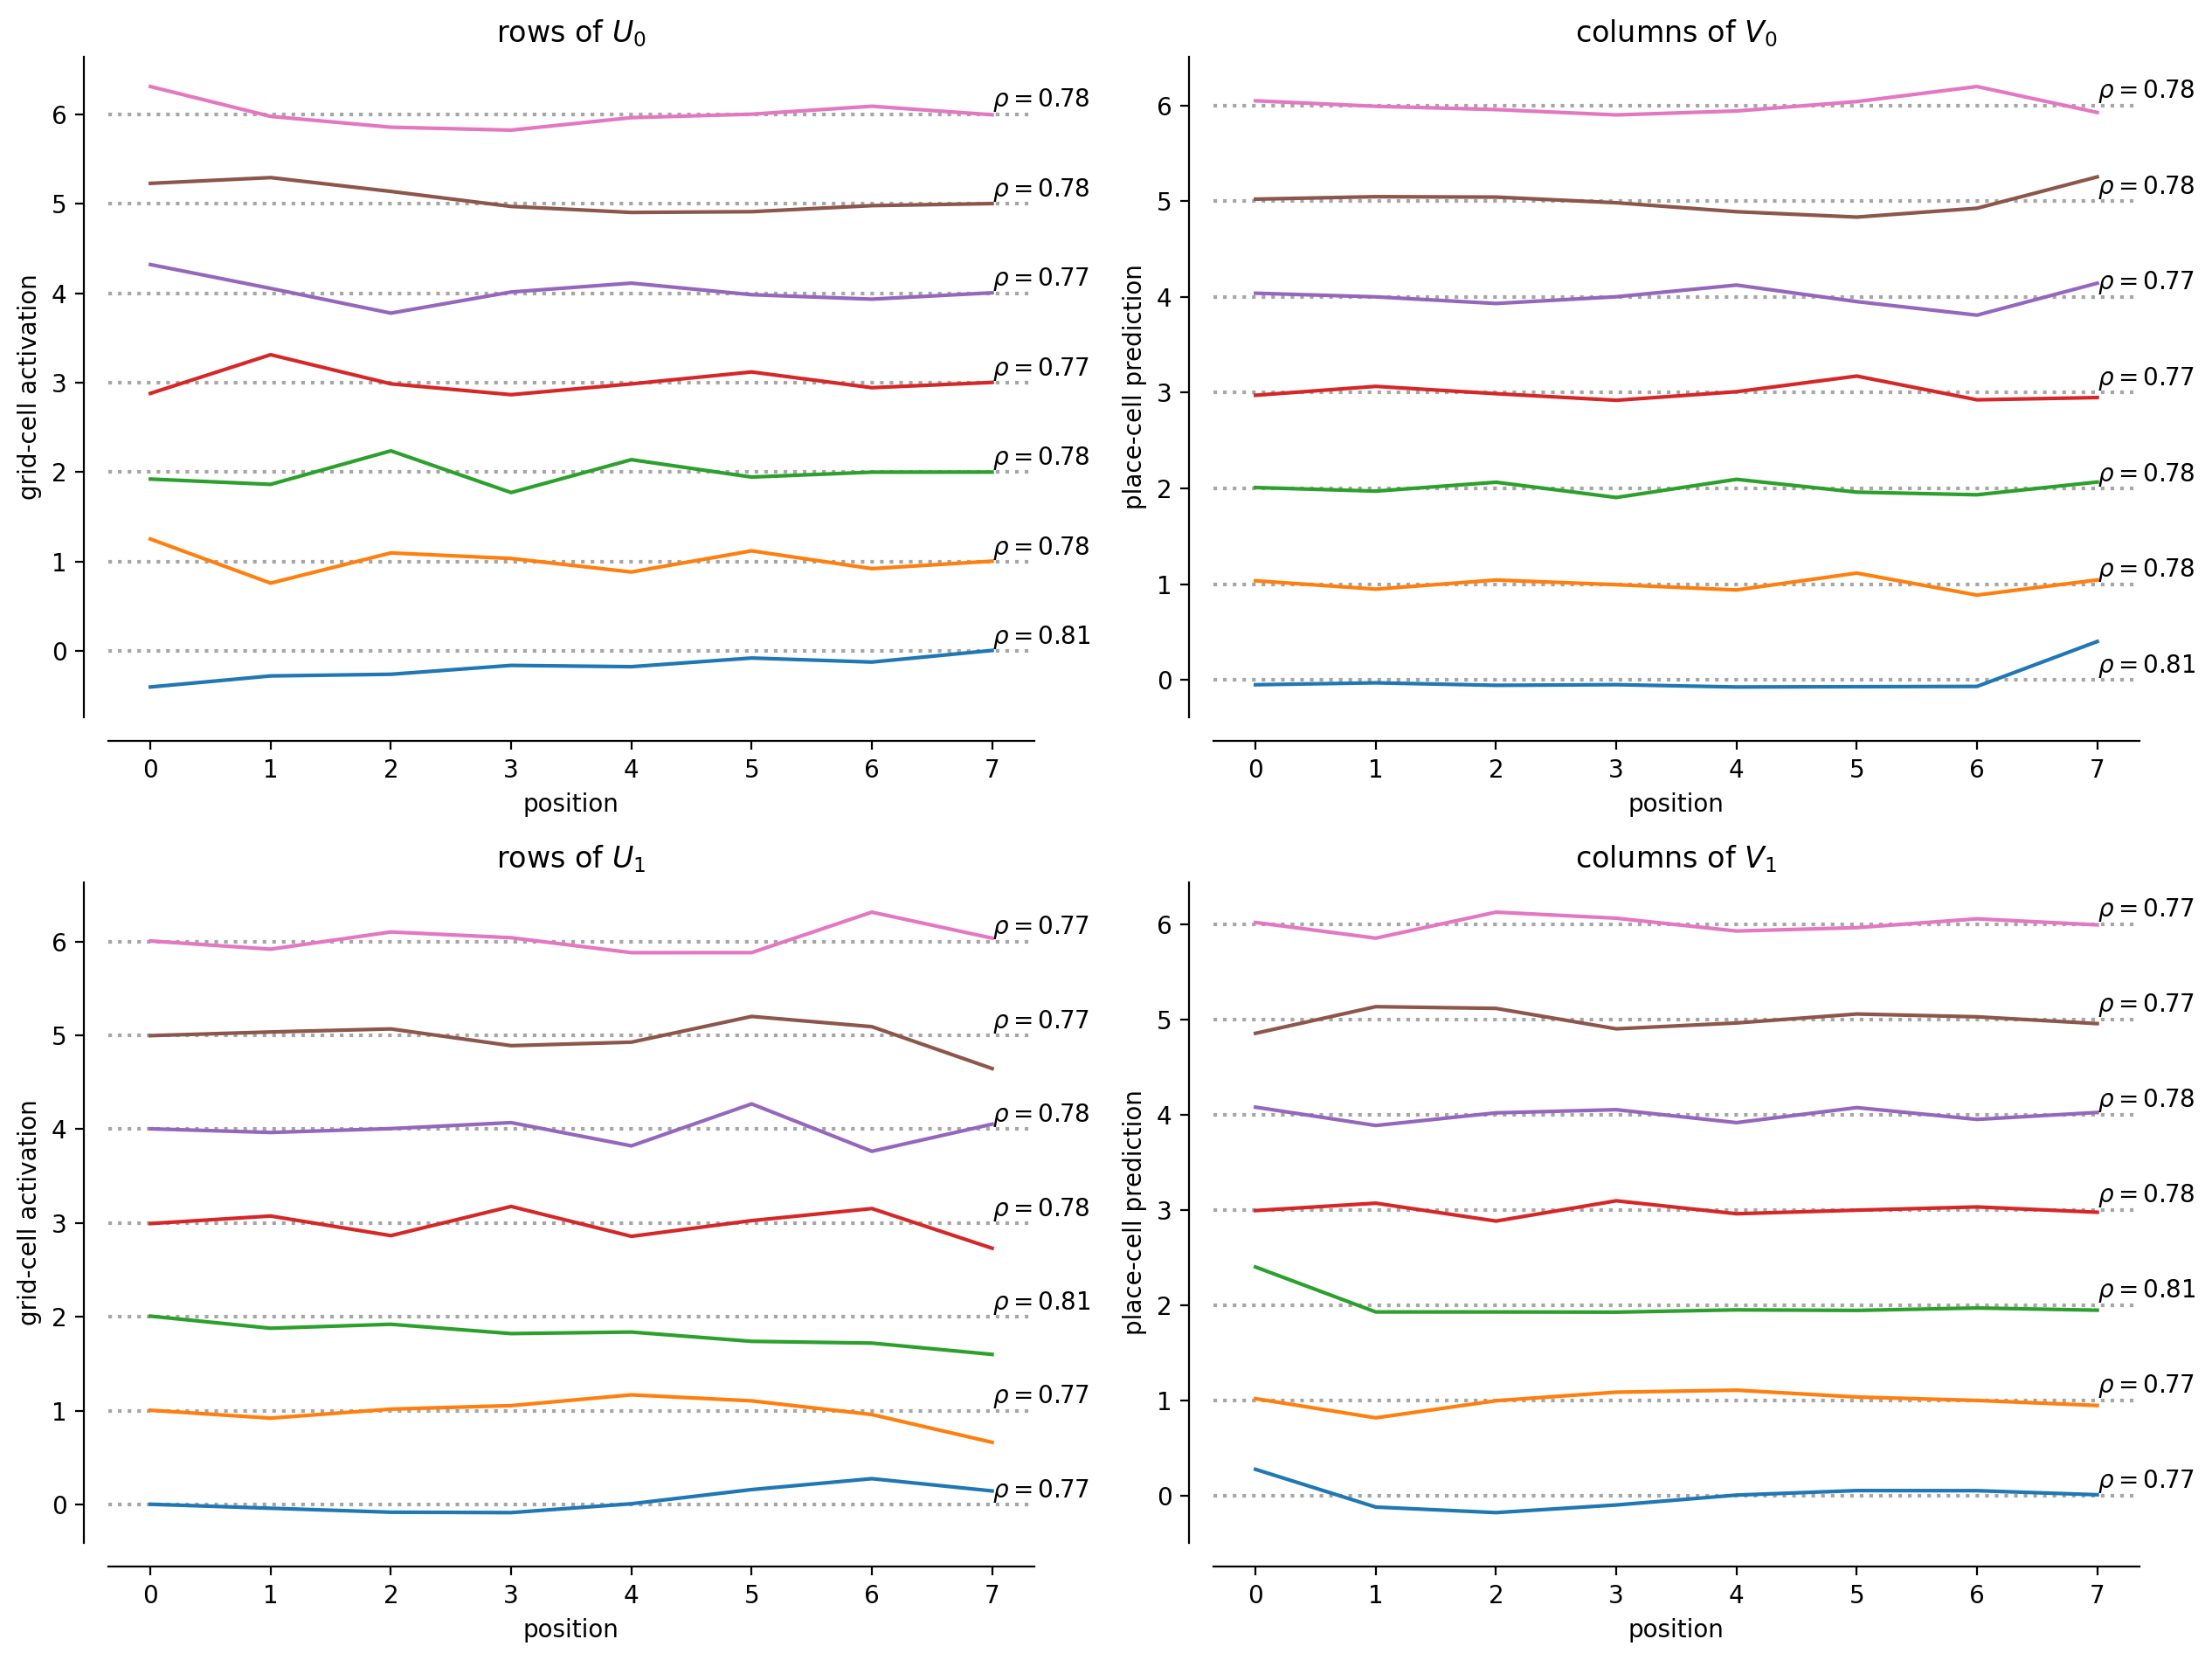

In [18]:
with dv.FigureManager(system.n_ctrl, 2) as (_, axs):
    for k in range(system.n_ctrl):
        ax_row = axs[k]
        crt_d = {f"rows of $U_{k}$": system.U[k].T, f"columns of $V_{k}$": system.V[k]}
        
        crt_theta = system.theta[k].detach().numpy()
        crt_full_theta = np.repeat(crt_theta, 2)
        
        crt_rho = (1 / torch.cosh(system.xi[k])).detach().numpy()
        if len(crt_theta) % 2 == 0:
            crt_full_rho = np.repeat(crt_rho, 2)
        else:
            crt_full_rho = np.hstack((np.repeat(crt_rho[:-1], 2), crt_rho[[-1]]))
            crt_full_theta = np.hstack((crt_full_theta, [0]))
        
        crt_value = crt_full_rho + 0.02 * (crt_full_theta % (2 * np.pi))
        crt_ordering = np.argsort(crt_value)
        
        for i, crt_name in enumerate(crt_d):
            ax = ax_row[i]
            crt_mat = crt_d[crt_name].detach().numpy()
            
            crt_mat = crt_mat[:, crt_ordering]
            
            crt_lim = np.max(np.abs(crt_mat))
            for k in range(m):
                crt_v = crt_mat[:, k]
                ax.axhline(k, ls=":", c="gray", alpha=0.7)
                ax.plot(np.arange(n), k + 0.4 * crt_v / crt_lim)
                
                ax.annotate(
                    f"$\\rho={crt_full_rho[crt_ordering][k]:.2f}$",
                    (n - 1, k),
                    xytext=(0, 3),
                    textcoords="offset points",
                )
            
            ax.set_xlabel("position")
            if i == 0:
                ax.set_ylabel("grid-cell activation")
            else:
                ax.set_ylabel("place-cell prediction")
            ax.set_title(crt_name)

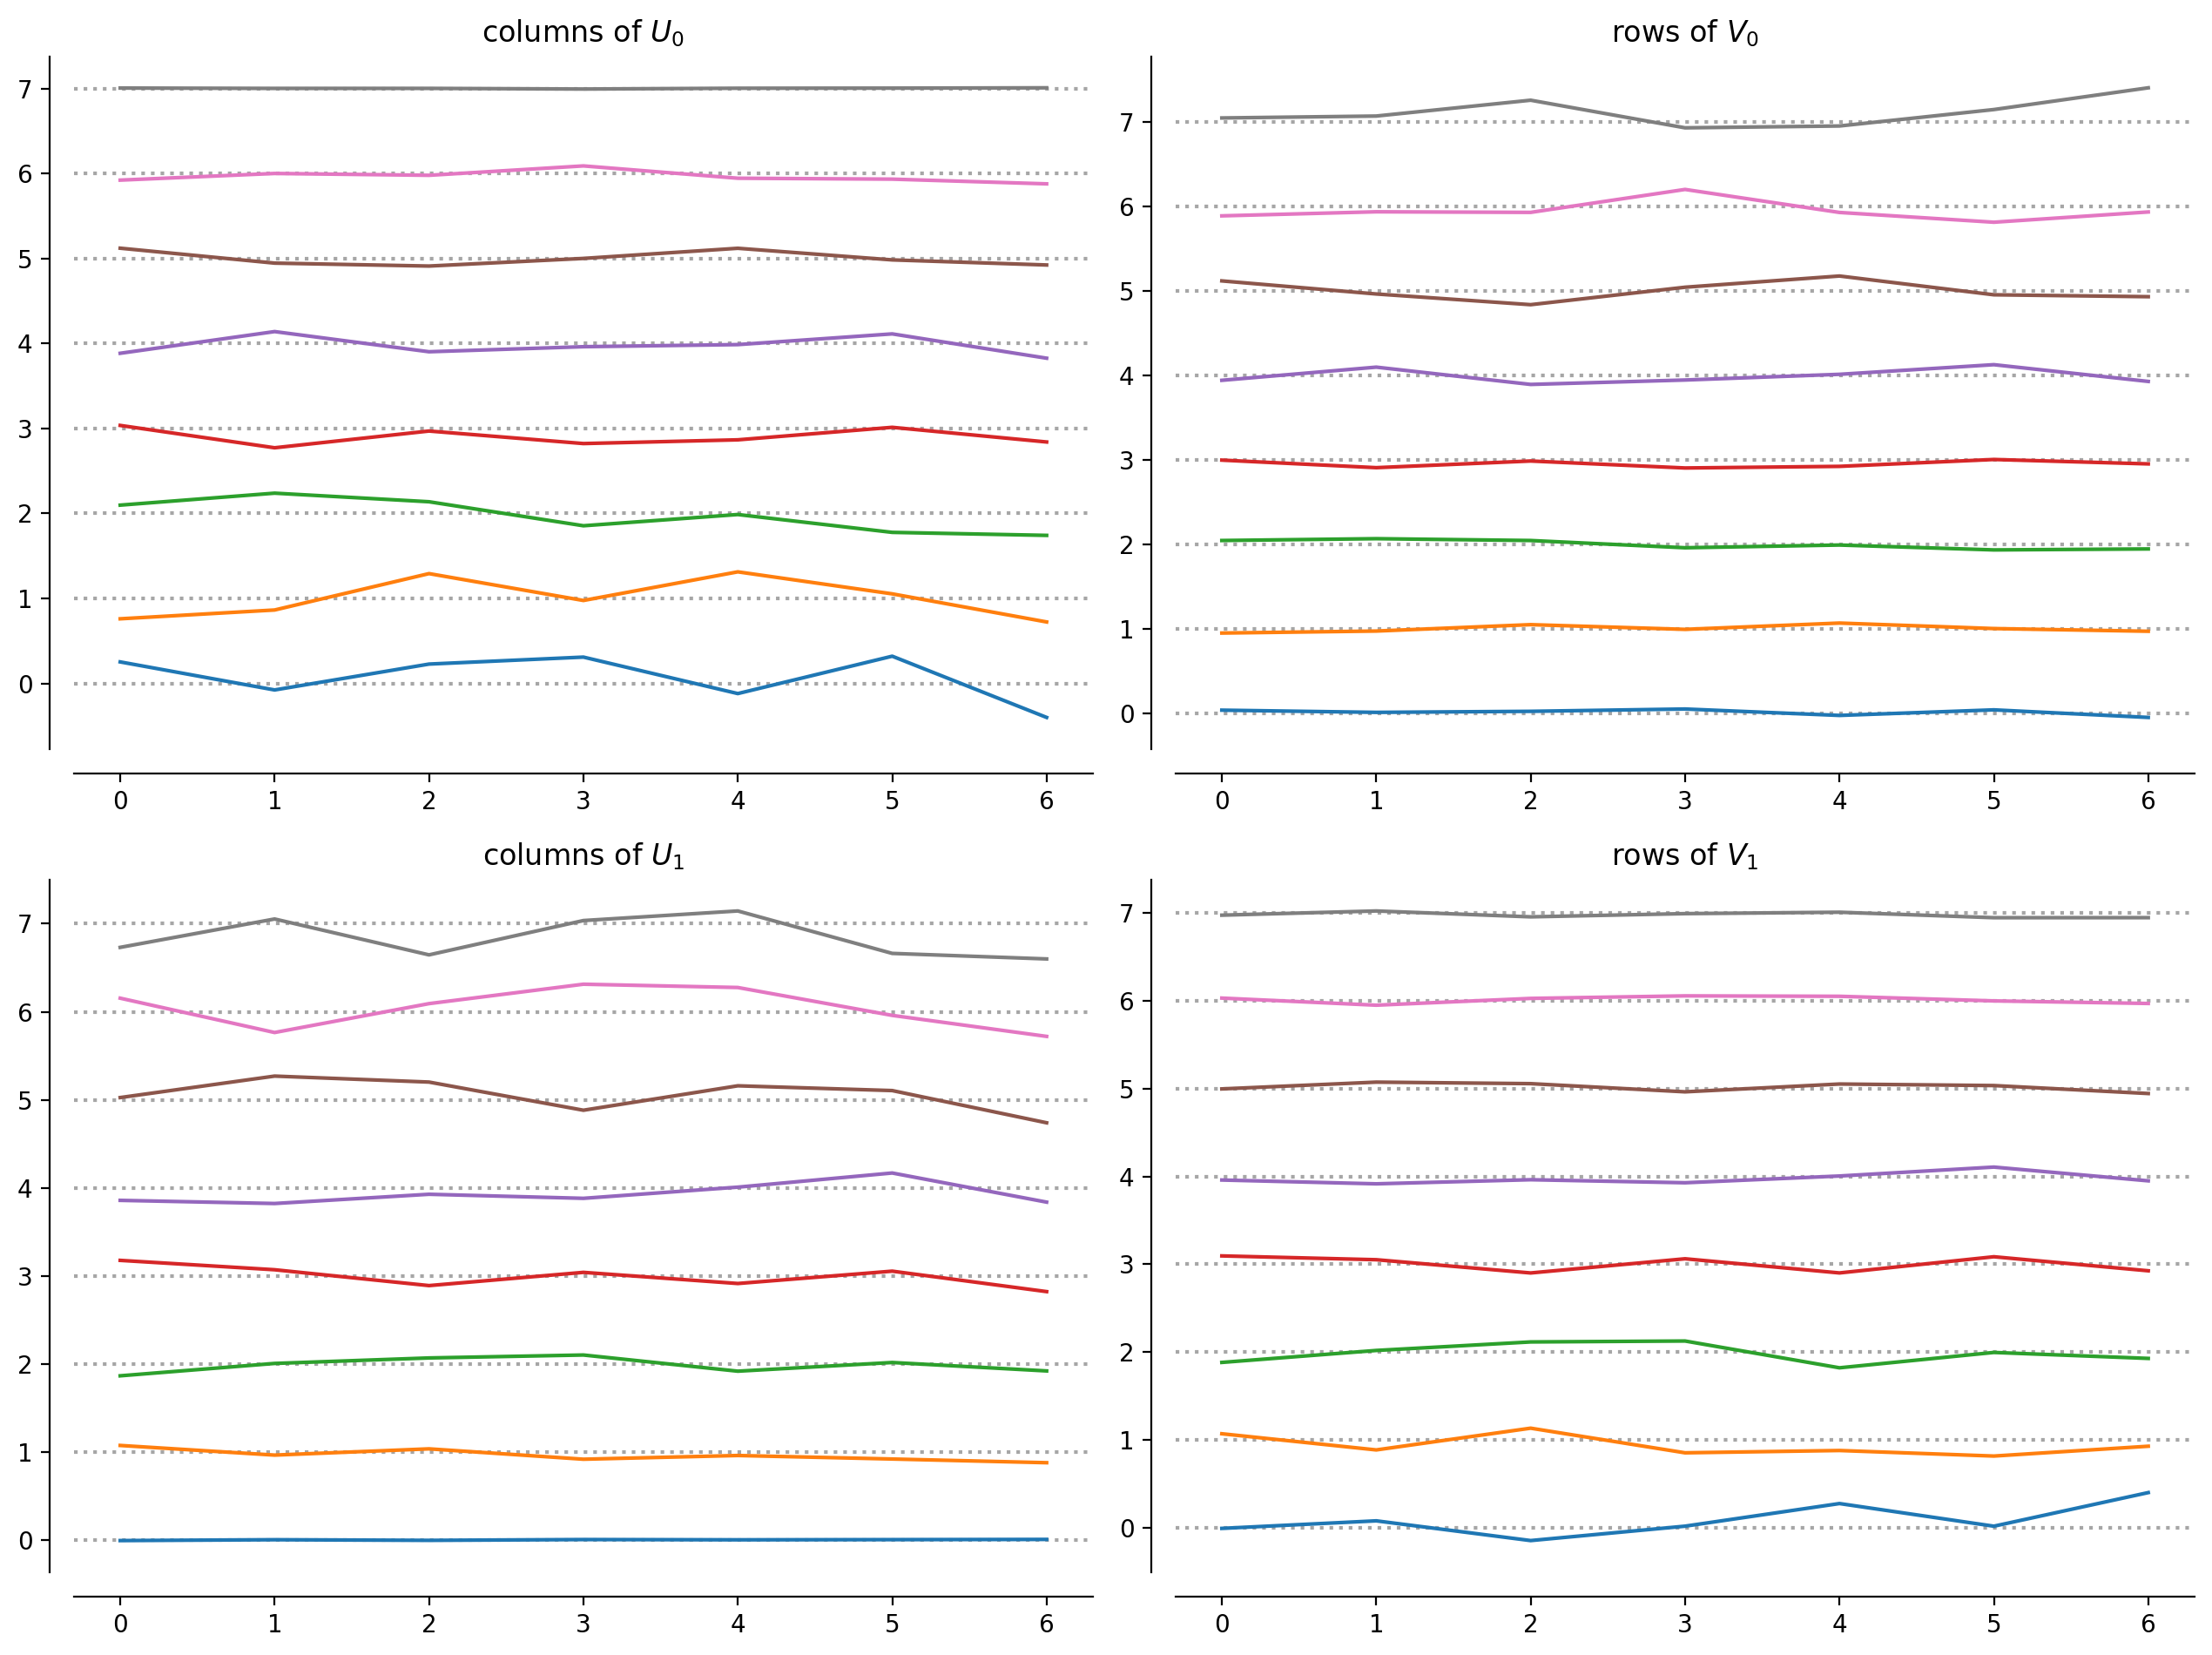

In [19]:
with dv.FigureManager(system.n_ctrl, 2) as (_, axs):
    for k in range(system.n_ctrl):
        ax_row = axs[k]
        crt_d = {f"columns of $U_{k}$": system.U[k], f"rows of $V_{k}$": system.V[k].T}
        for i, crt_name in enumerate(crt_d):
            ax = ax_row[i]
            crt_mat = crt_d[crt_name].detach().numpy()
            crt_lim = np.max(np.abs(crt_mat))
            for k in range(n):
                crt_v = crt_mat[:, k]
                ax.axhline(k, ls=":", c="gray", alpha=0.7)
                ax.plot(np.arange(m), k + 0.4 * crt_v / crt_lim)

            ax.set_title(crt_name)

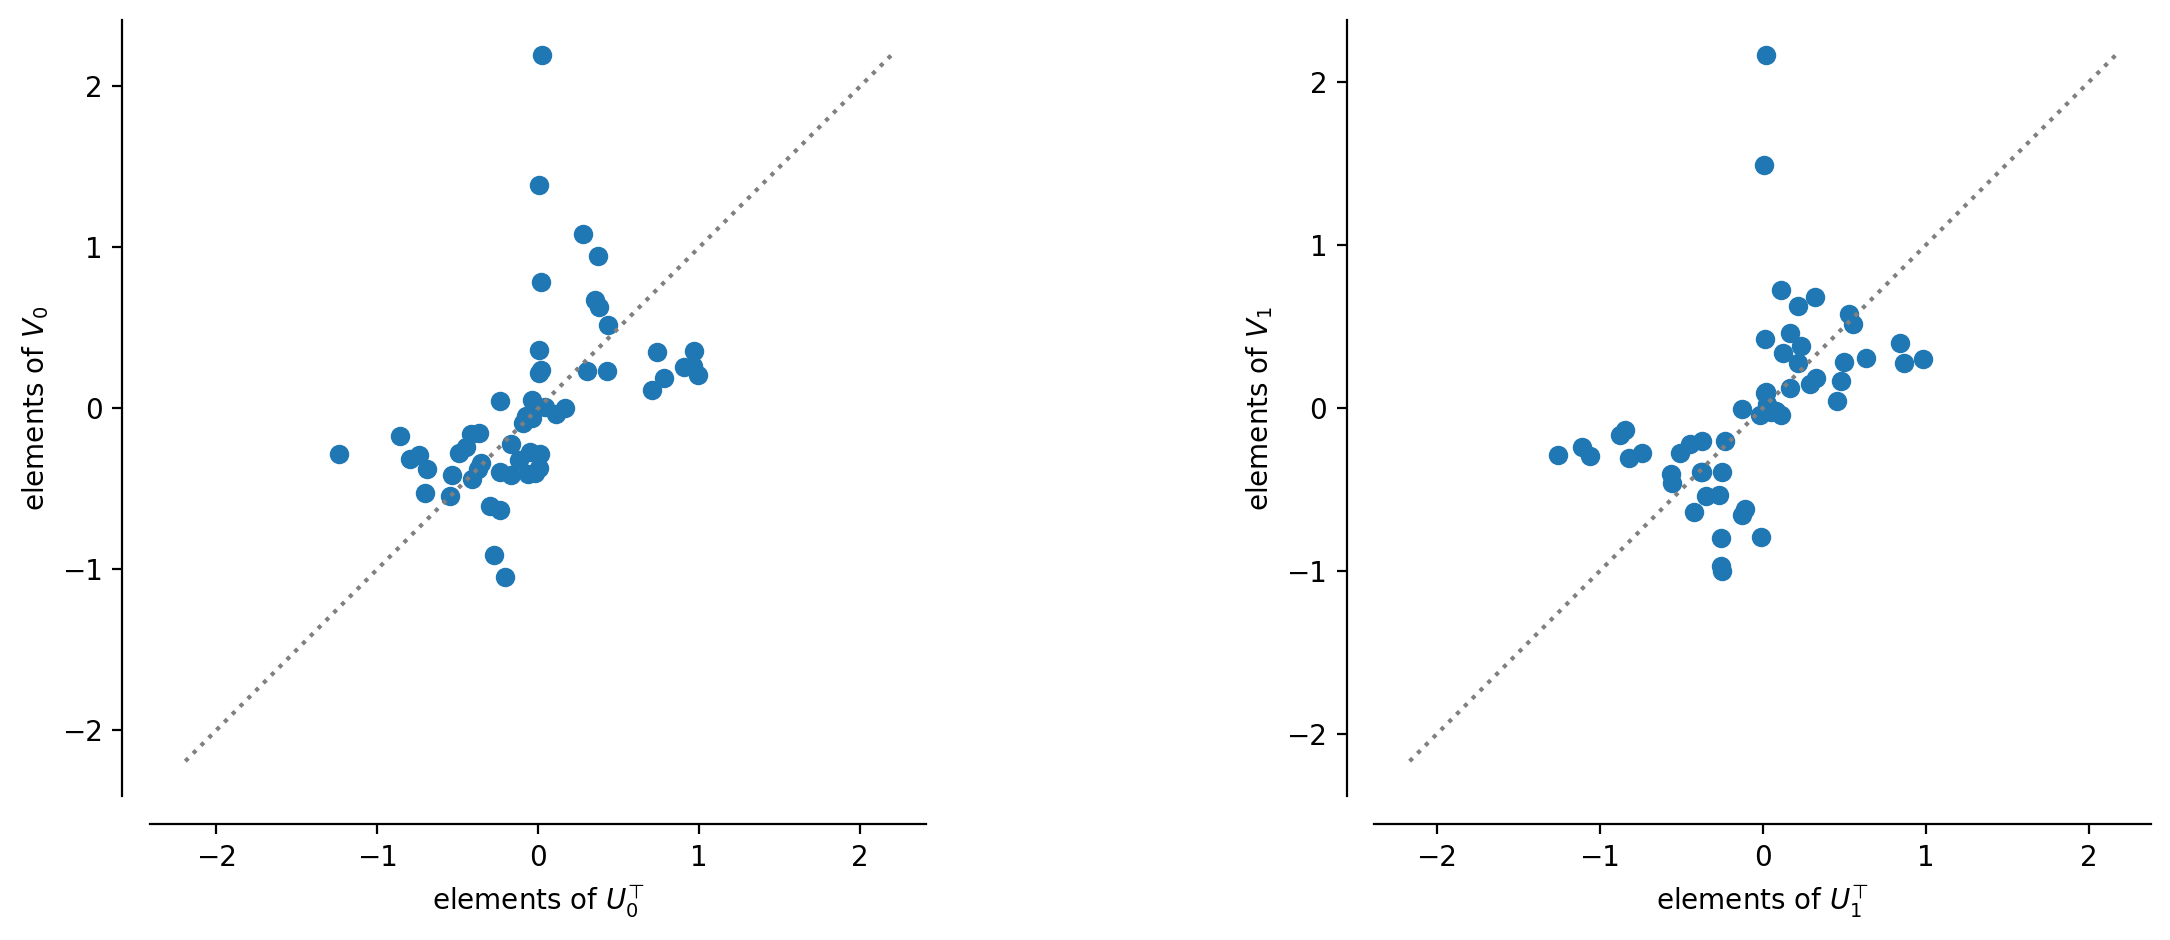

In [20]:
with dv.FigureManager(1, system.n_ctrl) as (_, axs):
    for k, ax in enumerate(axs):
        crt_u = system.U[k].detach().numpy()
        crt_vt = system.V[k].T.detach().numpy()
        crt_lim = max(np.max(np.abs(_)) for _ in [crt_u, crt_vt])
        ax.plot([-crt_lim, crt_lim], [-crt_lim, crt_lim], c="gray", ls=":")
        ax.scatter(crt_u, crt_vt)
        ax.set_xlabel(f"elements of $U_{k}^\\top$")
        ax.set_ylabel(f"elements of $V_{k}$")

        ax.set_aspect(1)